[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/latent-variable-models/latent_variable_models_part_2.ipynb)

In [ ]:
try:
    # Use Tensorflow 2.x
    %tensorflow_version 2.x
    # Check if notebook is running in Google Colab
    import google.colab
except:
    pass

# Latent variable models, part 2: Stochastic variational inference and variational autoencoders

[Part 1](latent_variable_models_part_1.ipynb) of this article series introduced a latent variable model with discrete latent variables, the Gaussian mixture model (GMM), and an algorithm to fit this model to data, the EM algorithm. Part 2 covers a latent variable model with continuous latent variables for modeling more complex data, like natural images for example, and a Bayesian inference technique that can be used in conjunction with stochastic optimization algorithms.

Consider a natural image of size $100 \times 100$ with a single channel. This image is a point in $10.000$-dimensional space. Natural images are usually not uniformly distributed in this space but reside on a much lower-dimensional manifold within this high-dimensional space. The lower dimensionality of the manifold is related to the limited degrees of freedom in these images e.g. only a limited number of pixel value combinations are actually perceived as natural images. 

Modeling natural images with latent variable models whose continuous latent variables represent locations on the manifold can be a useful approach that is also discussed here. As in part 1, a model with one latent variable $\mathbf{t}_i$ per observation $\mathbf{x}_i$ is used but now the latent variables are continuous rather than discrete variables. Therefore, summations over latent variable states are now replaced by integrals and these are often intractable for more complex models. 

Observations i.e. images $\mathbf{X} = \left\{ \mathbf{x}_1, \ldots, \mathbf{x}_N \right\}$ are again described with a probabilistic model $p(\mathbf{x} \lvert \boldsymbol{\theta})$. Goal is to maximize the data likelihood $p(\mathbf{X} \lvert \boldsymbol{\theta})$ w.r.t. $\boldsymbol{\theta}$ and to obtain approximate posterior distributions over continuous latent variables. The joint distribution over an observed variable $\mathbf{x}$ and a latent variable $\mathbf{t}$ is defined as the product of the conditional distribution over $\mathbf{x}$ given $\mathbf{t}$ and the prior distribution over $\mathbf{t}$.

$$
p(\mathbf{x}, \mathbf{t} \lvert \boldsymbol{\theta}) = p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta}) p(\mathbf{t} \lvert \boldsymbol{\theta})
\tag{1}
$$

We obtain the marginal distribution over x by integrating over t.

$$
p(\mathbf{x} \lvert \boldsymbol{\theta}) = \int p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta}) p(\mathbf{t} \lvert \boldsymbol{\theta}) d\mathbf{t}
\tag{2}
$$

This integral is usually intractable for even moderately complex conditional probabilities $p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta})$ and consequently also the true posterior.

$$
p(\mathbf{t} \lvert \mathbf{x}, \boldsymbol{\theta}) = {{p(\mathbf{x} \lvert \mathbf{t}, \boldsymbol{\theta}) p(\mathbf{t} \lvert \boldsymbol{\theta})} \over {p(\mathbf{x} \lvert \boldsymbol{\theta})}}
\tag{3}
$$

This means that the E-step of the EM algorithm becomes intractable. Recall from part 1 that the lower bound of the log marginal likelihood is given by 

$$
\mathcal{L}(\boldsymbol{\theta}, q) = \log p(\mathbf{X} \lvert \boldsymbol{\theta}) - \mathrm{KL}(q(\mathbf{T} \lvert \mathbf{X}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}))
\tag{4}
$$

In the E-step, the lower bound is maximized w.r.t. $q$ and $\boldsymbol{\theta}$ is held fixed. If the true posterior is tractable, we can set $q$ to the true posterior so that the KL divergence becomes $0$ which maximizes the lower bound for the current value of $\boldsymbol{\theta}$. If the true posterior is intractable approximations must be used. 

Here, we will use *stochastic variational inference*, a Bayesian inference method that also scales to large datasets<sup>[1]</sup>. Numerous other approximate inference approaches exist but these are not discussed here to keep the article focused.

## Stochastic variational inference

The field of mathematics that covers the optimization of a functional w.r.t. a function, like ${\mathrm{argmax}}_q \mathcal{L}(\boldsymbol{\theta}, q)$ in our example, is the [calculus of variations](https://en.wikipedia.org/wiki/Calculus_of_variations), hence the name *variational inference*. In this context, $q$ is called a *variational distribution* and $\mathcal{L}(\boldsymbol{\theta}, q)$ a *variational lower bound*. 

We will approximate the true posterior with a parametric variational distribution $q(\mathbf{t} \lvert \mathbf{x}, \boldsymbol{\phi})$ and try to find a value of $\boldsymbol{\phi}$ that minimizes the KL divergence between this distribution and the true posterior. Using $q(\mathbf{t} \lvert \mathbf{x}, \boldsymbol{\phi})$ we can formulate the variational lower bound for a single observation $\mathbf{x}_i$ as

$$
\begin{align*}
\mathcal{L}(\boldsymbol{\theta}, q; \mathbf{x}_i) &=
\log p(\mathbf{x}_i \lvert \boldsymbol{\theta}) - \mathrm{KL}(q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \mid\mid p(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\theta})) \\ &= 
\log p(\mathbf{x}_i \lvert \boldsymbol{\theta}) - \int q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \log {{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \over {p(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\theta})}} d\mathbf{t}_i \\ &= 
\int q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \log {{p(\mathbf{x}_i \lvert \boldsymbol{\theta}) p(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\theta})} \over {q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})}} d\mathbf{t}_i \\ &= 
\int q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \log {{p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) p(\mathbf{t}_i \lvert \boldsymbol{\theta})} \over {q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})}} d\mathbf{t}_i \\ &=
\int q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) d\mathbf{t}_i - \mathrm{KL}(q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \mid\mid p(\mathbf{t}_i \lvert \boldsymbol{\theta})) \\ &=
\mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) - \mathrm{KL}(q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \mid\mid p(\mathbf{t}_i \lvert \boldsymbol{\theta})) 
\end{align*}
\tag{5}
$$

We assume that the integral $\int q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) d\mathbf{t}_i$ is intractable but we can choose a functional form of $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ from which we can easily sample so that the expectation of $\log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})$ w.r.t. to $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ can be approximated with $L$ samples from $q$. 

$$
\mathcal{L}(\boldsymbol{\theta}, q; \mathbf{x}_i) \approx {1 \over L} \sum_{l=1}^L \log p(\mathbf{x}_i \lvert \mathbf{t}_{i,l}, \boldsymbol{\theta}) - \mathrm{KL}(q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \mid\mid p(\mathbf{t}_i \lvert \boldsymbol{\theta}))
\tag{6}
$$

where $\mathbf{t}_{i,l} \sim q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$. We will also choose the functional form of $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ and $p(\mathbf{t}_i \lvert \boldsymbol{\theta})$ such that integration of the KL divergence can be done analytically, hence, no samples are needed to evaluate the KL divergence. With these choices, an approximate evaluation of the variational lower bound is possible. But in order to optimize the lower bound w.r.t. $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ we need to approximate the gradients w.r.t. these parameters.

### Stochastic gradients

We first assume that the analytical expression of the KL divergence, the second term on the RHS of Eq. $(5)$, is differentiable w.r.t. $\boldsymbol{\phi}$ and $\boldsymbol{\theta}$ so that deterministic gradients can be computed. The gradient of the first term on the RHS of Eq. $(5)$ w.r.t. $\boldsymbol{\theta}$ is

$$
\nabla_{\boldsymbol{\theta}} \mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) =
\mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \nabla_{\boldsymbol{\theta}} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})
\tag{7}
$$

Here, $\nabla_{\boldsymbol{\theta}}$ can be moved inside the expectation as $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ doesn't depend on $\boldsymbol{\theta}$. Assuming that $p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})$ is differentiable w.r.t. $\boldsymbol{\theta}$, unbiased estimates of the gradient can be obtained by sampling from $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$.

$$
\nabla_{\boldsymbol{\theta}} \mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) \approx 
{1 \over L} \sum_{l=1}^L \nabla_{\boldsymbol{\theta}} \log p(\mathbf{x}_i \lvert \mathbf{t}_{i,l}, \boldsymbol{\theta})
\tag{8}
$$

We will later implement $p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})$ as neural network and use Tensorflow to compute $\nabla_{\boldsymbol{\theta}} \log p(\mathbf{x}_i \lvert \mathbf{t}_{i,l}, \boldsymbol{\theta})$. The gradient w.r.t. $\boldsymbol{\phi}$ is a bit more tricky as $\nabla_{\boldsymbol{\phi}}$ cannot be moved inside the expectation because $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ depends on $\boldsymbol{\phi}$. But if we can decompose $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ into an auxiliary distribution $p(\boldsymbol\epsilon)$ that doesn't depend on $\boldsymbol{\phi}$ and a deterministic, differentiable function $g(\boldsymbol\epsilon, \mathbf{x}, \boldsymbol{\phi})$ where $\mathbf{t}_i = g(\boldsymbol\epsilon, \mathbf{x}_i, \boldsymbol{\phi})$ and $\boldsymbol\epsilon \sim p(\boldsymbol\epsilon)$ then we can re-formulate the gradient w.r.t. $\boldsymbol{\phi}$ as

$$
\begin{align*}
\nabla_{\boldsymbol{\phi}} \mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) &=
\nabla_{\boldsymbol{\phi}} \mathbb{E}_{p(\boldsymbol\epsilon)} \log p(\mathbf{x}_i \lvert g(\boldsymbol\epsilon, \mathbf{x}_i, \boldsymbol{\phi}), \boldsymbol{\theta}) \\ &=
\mathbb{E}_{p(\boldsymbol\epsilon)} \nabla_{\boldsymbol{\phi}} \log p(\mathbf{x}_i \lvert g(\boldsymbol\epsilon, \mathbf{x}_i, \boldsymbol{\phi}), \boldsymbol{\theta})
\tag{9}
\end{align*}
$$

Unbiased estimates of the gradient w.r.t. $\boldsymbol{\phi}$ can then be obtained by sampling from $p(\boldsymbol\epsilon)$.

$$
\nabla_{\boldsymbol{\phi}} \mathbb{E}_{q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})} \log p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta}) \approx
{1 \over L} \sum_{l=1}^L \nabla_{\boldsymbol{\phi}} \log p(\mathbf{x}_i \lvert \mathbf{t}_{i,l}, \boldsymbol{\theta})
\tag{10}
$$


where $\mathbf{t}_{i,l} = g(\boldsymbol\epsilon_l, \mathbf{x}_i, \boldsymbol{\phi})$ and $\boldsymbol\epsilon_l \sim p(\boldsymbol\epsilon)$. This so-called *reparameterization trick* can be applied to a wide range of probability distributions, including Gaussian distributions. Furthermore, stochastic gradients w.r.t. $\boldsymbol{\phi}$ obtained with this trick have much smaller variance than those obtained with alternative approaches (not shown here).

### Mini-batches

The above approximations for the variational lower bound and its gradients have been formulated for a single training example $\mathbf{x}_i$ but this can be easily extended to mini-batches $\mathbf{X}^M = \left\{ \mathbf{x}_1, \ldots, \mathbf{x}_M \right\}$ with $M$ random samples from a dataset $\mathbf{X}$ of $N$ i.i.d. observations. The lower bound of the full dataset $\mathcal{L}(\boldsymbol{\theta}, q; \mathbf{X})$ can then be approximated as

$$
\begin{align*}
\mathcal{L}(\boldsymbol{\theta}, q; \mathbf{X}) &\approx
{N \over M} \sum_{i=1}^M \mathcal{L}(\boldsymbol{\theta}, q; \mathbf{x}_i) \\ &=
\mathcal{L}^M(\boldsymbol{\theta}, q; \mathbf{X}^M)
\tag{11}
\end{align*}
$$

Gradients of $\mathcal{L}^M(\boldsymbol{\theta}, q; \mathbf{X}^M)$ can be obtained as described above together with averaging over the mini-batch and used in combination with optimizers like Adam, for example, to update the parameters of the latent variable model. Sampling from the variational distribution $q$ and usage of mini-batches leads to noisy gradients, hence the term *stochastic variational inference*. 

If $M$ is sufficiently large, for example $M = 100$, then $L$ can be even set to $1$ i.e. a single sample from the variational distribution per training example is sufficient to get a good gradient estimate on average.

## Variational autoencoder

From the perspective of a generative model, $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ is a probabilistic *encoder* because it generates a *latent code* $\mathbf{t}_i$ for input image $\mathbf{x}_i$ and $p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})$ is a probabilistic *decoder* because it generates or reconstructs an image $\mathbf{x}_i$ from latent code $\mathbf{t}_i$. Optimizing the variational lower bound w.r.t. parameters $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ can therefore be regarded as training a probabilistic autoencoder or *variational autoencoder* (VAE)<sup>[1]</sup>.

In this context, the first term on the RHS of Eq. $(5)$ can be interpreted as expected negative *reconstruction error*. The second term is a *regularization term* that encourages the variational distribution to be close to the prior over latent variables. If the regularization term is omitted, the variational distribution would collapse to a delta function and the variational autoencoder would degenerate to a "usual" deterministic autoencoder. 

### Implementation

For implementing a variational autoencoder, we make the following choices:

- The variational distribution $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ is a multivariate Gaussian $\mathcal{N}(\mathbf{t}_i \lvert \boldsymbol\mu(\mathbf{x}_i, \boldsymbol{\phi}), \boldsymbol\sigma^2(\mathbf{x}_i, \boldsymbol{\phi}))$  with a diagonal covariance matrix where mean vector $\boldsymbol\mu$ and the covariance diagonal $\boldsymbol\sigma^2$ are functions of $\mathbf{x}_i$ and $\boldsymbol{\phi}$. These functions are implemented as neural network and learned during optimization of the lower bound w.r.t. $\boldsymbol{\phi}$. After reparameterization, samples from $q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi})$ are obtained via the deterministic function $g(\boldsymbol\epsilon, \mathbf{x}_i, \boldsymbol{\phi}) = \boldsymbol\mu(\mathbf{x}_i, \boldsymbol{\phi}) + \boldsymbol\sigma^2(\mathbf{x}_i, \boldsymbol{\phi}) \odot \boldsymbol\epsilon$ and an auxiliary distribution $p(\boldsymbol\epsilon) = \mathcal{N}(\boldsymbol\epsilon \lvert \mathbf{0}, \mathbf{I})$.

- The conditional distribution $p(\mathbf{x}_i \lvert \mathbf{t}_i, \boldsymbol{\theta})$ is a multivariate Bernoulli distribution $\text{Ber}(\mathbf{x}_i \lvert \mathbf{k}(\mathbf{t}_i, \boldsymbol{\theta}))$ where parameter $\mathbf{k}$ is a function of $\mathbf{t}_i$ and $\boldsymbol{\theta}$. This distribution models the binary training data i.e. monochrome (= binarized) MNIST images in our example. Function $\mathbf{k}$ computes for each pixel its expected value. It is also implemented as neural network and learned during optimization of the lower bound w.r.t. $\boldsymbol{\theta}$. Taking the (negative) logarithm of $\text{Ber}(\mathbf{x}_i \lvert \mathbf{k}(\mathbf{t}_i, \boldsymbol{\theta}))$ gives a sum over pixel-wise binary cross entropies as shown in Eq. $(12)$

- Prior $p(\mathbf{t}_i \lvert \boldsymbol{\theta})$ is a multivariate Gaussian distribution $\mathcal{N}(\mathbf{t}_i \lvert \mathbf{0}, \mathbf{I})$ with zero mean and unit covariance matrix. With the chosen functional forms of the prior and the variational distribution $q$, $\mathrm{KL}(q(\mathbf{t}_i \lvert \mathbf{x}_i, \boldsymbol{\phi}) \mid\mid p(\mathbf{t}_i \lvert \boldsymbol{\theta}))$ can be integrated analytically to $-{1 \over 2} \sum_{d=1}^D (1 + \log \sigma_{i,d}^2 - \mu_{i,d}^2 - \sigma_{i,d}^2)$ where $D$ is the dimensionality of the latent space and $\mu_{i,d}$ and $\sigma_{i,d}$ is the $d$-th element of $\boldsymbol\mu(\mathbf{x}_i, \boldsymbol{\phi})$ and $\boldsymbol\sigma(\mathbf{x}_i, \boldsymbol{\phi})$, respectively.

Using these choices and setting $L = 1$, the variational lower bound for a single image $\mathbf{x}_i$ can be approximated as

$$
\mathcal{L}(\boldsymbol{\theta}, q; \mathbf{x}_i) \approx 
- \sum_c \left(x_{i,c} \log k_{i,c} + (1 - x_{i,c}) \log (1 - k_{i,c})\right) + {1 \over 2} \sum_d (1 + \log \sigma_{i,d}^2 - \mu_{i,d}^2 - \sigma_{i,d}^2)
\tag{12}
$$

where $x_{i,c}$ is the value of pixel $c$ in image $\mathbf{x}_i$ and $k_{i,c}$ its expected value. The negative value of the lower bound is used as loss during training. The following figure outlines the architecture of the variational autoencoder. 

![VAE](images/vae/auto-encoder.jpg)

The definitions of the encoder and decoder neural networks were taken from \[2\]. Here, the encoder computes the logarithm of the variance, instead of the variance directly, for reasons of numerical stability. 

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model


def create_encoder(latent_dim):
    """
    Creates a convolutional encoder for MNIST images.

    Args:
        latent_dim: dimensionality of latent space.
    """
    encoder_iput = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_iput)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    q_mean = layers.Dense(latent_dim)(x)
    q_log_var = layers.Dense(latent_dim)(x)

    return Model(encoder_iput, [q_mean, q_log_var], name='encoder')


def create_decoder(latent_dim):
    """
    Creates a convolutional decoder for MNIST images.

    Args:
        latent_dim: dimensionality of latent space.
    """
    decoder_input = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(12544, activation='relu')(decoder_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    k = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    
    return Model(decoder_input, k, name='decoder')

These definitions are used to implement a `VariationalAutoencoder` model class.

In [2]:
import tensorflow as tf

class VariationalAutoencoder(Model):
    def __init__(self, latent_dim=2):
        """
        Creates a variational autoencoder Keras model.
        
        Args:
            latent_dim: dimensionality of latent space.
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = create_encoder(latent_dim)
        self.decoder = create_decoder(latent_dim)
    
    def encode(self, x):
        """
        Computes variational distribution q statistics from 
        input image x.
        
        Args:
            x: input image, shape (M, 28, 28, 1).
            
        Returns:
            Mean, shape (M, latent_dim), and log variance, 
            shape (M, latent_dim), of multivariate Gaussian 
            distribution q.        
        """
        q_mean, q_log_var = self.encoder(x)
        return q_mean, q_log_var
    
    def sample(self, q_mean, q_log_var):
        """
        Samples latent code from variational distribution q.
        
        Args:
            q_mean: mean of q, shape (M, latent_dim).
            q_log_var: log variance of q, shape (M, latent_dim).
            
        Returns:
            Latent code sample, shape (M, latent_dim).
        """
        eps = tf.random.normal(shape=q_mean.shape)
        return q_mean + tf.exp(q_log_var * .5) * eps
        
    def decode(self, t):
        """
        Computes expected pixel values (= probabilities k) from 
        latent code t.
        
        Args:
            t: latent code, shape (M, latent_dim).

        Returns:
            Probabilities k of multivariate Bernoulli 
            distribution p, shape (M, 28, 28, 1).
        """
        k = self.decoder(t)
        return k
    
    def call(self, x):
        """
        Computes expected pixel values (= probabilities k) of a 
        reconstruction of input image x. 
                
        Args:
            x: input image, shape (M, 28, 28, 1).

        Returns:
            Probabilities k of multivariate Bernoulli 
            distribution p, shape (M, 28, 28, 1).
        """
        q_mean, q_log_var = self.encode(x)
        t = self.sample(q_mean, q_log_var)
        return self.decode(t)

The `variational_lower_bound` function is implemented using Eq. $(12)$ and Eq. $(11)$ but instead of estimating the lower bound for the full dataset it is normalized by the dataset size $N$.

In [3]:
from tensorflow.keras.losses import binary_crossentropy

def variational_lower_bound(model, x):
    """
    Computes normalized variational lower bound.
    
    Args:
        x: input images, shape (M, 28, 28, 1)
        
    Returns:
        Variational lower bound averaged over M 
        samples in batch and normalized by dataset
        size N.
    """
    q_mean, q_log_var = model.encode(x)
    t = model.sample(q_mean, q_log_var)
    x_rc = model.decode(t)
    
    # Expected negative reconstruction error
    neg_rc_error = -tf.reduce_sum(binary_crossentropy(x, x_rc), axis=[1, 2])

    # Regularization term (negative KL divergence)
    neg_kl_div = 0.5 * tf.reduce_sum(1 + q_log_var \
                                 - tf.square(q_mean) \
                                 - tf.exp(q_log_var), axis=-1)
    
    # Average over mini-batch (of size M)
    return tf.reduce_mean(neg_rc_error + neg_kl_div)

The training procedure uses the negative value of the variational lower bound as loss to compute stochastic gradient estimates. These are used by the `optimizer` to update model parameters $\boldsymbol\theta$ and $\boldsymbol\phi$. The normalized variational lower bound of the test set is computed at the end of each epoch and printed.

In [4]:
@tf.function
def train_step(model, optimizer, x):
    """Trains VAE on mini-batch x using optimizer.
    """
    with tf.GradientTape() as tape:
        # Compute neg. variational lower bound as loss
        loss = -variational_lower_bound(model, x)
    # Compute gradients from neg. variational lower bound
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to model parameters theta and phi
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    
def train(model, optimizer, ds_train, ds_test, epochs):
    """Trains VAE on training dataset ds_train using 
       optimizer for given number of epochs.
    """
    for epoch in range(1, epochs + 1):
        for x in ds_train:
            train_step(model, optimizer, x)
            
        vlb_mean = tf.keras.metrics.Mean()
        for x in ds_test:
            vlb_mean(variational_lower_bound(model, x))
        vlb = vlb_mean.result()
        print(f'Epoch: {epoch:02d}, Test set VLB: {vlb:.2f}')


Since the data are modelled with a multivariate Bernoulli distribution, the MNIST images are first binarized to monochrome images so that their pixel values are either 0 or 1. The training batch size is set to 100 to get reliable stochastic gradient estimates.

In [5]:
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = (x_train > 127.5).astype('float32') # binarize
x_train = x_train.reshape(-1, 28, 28, 1)

x_test = (x_test > 127.5).astype('float32') # binarize
x_test = x_test.reshape(-1, 28, 28, 1)

batch_size = 100

ds_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices(x_test).shuffle(x_test.shape[0]).batch(batch_size)

We choose a two-dimensional latent space so that it can be easily visualized. Training the variational autoencoder with `RMSProp` as optimizer at a learning rate of `1e-3` for 20 epochs gives already reasonable results. This takes a few minutes on a single GPU.

In [6]:
vae = VariationalAutoencoder(latent_dim=2)
opt = tf.keras.optimizers.RMSprop(lr=1e-3)

In [7]:
train(model=vae, 
      optimizer=opt, 
      ds_train=ds_train, 
      ds_test=ds_test, 
      epochs=20)

Epoch: 01, Test set VLB: -166.56
Epoch: 02, Test set VLB: -158.25
Epoch: 03, Test set VLB: -154.44
Epoch: 04, Test set VLB: -152.20
Epoch: 05, Test set VLB: -150.47
Epoch: 06, Test set VLB: -148.30
Epoch: 07, Test set VLB: -148.63
Epoch: 08, Test set VLB: -146.66
Epoch: 09, Test set VLB: -145.61
Epoch: 10, Test set VLB: -147.64
Epoch: 11, Test set VLB: -148.42
Epoch: 12, Test set VLB: -143.86
Epoch: 13, Test set VLB: -143.31
Epoch: 14, Test set VLB: -145.67
Epoch: 15, Test set VLB: -143.78
Epoch: 16, Test set VLB: -143.29
Epoch: 17, Test set VLB: -142.25
Epoch: 18, Test set VLB: -142.99
Epoch: 19, Test set VLB: -143.39
Epoch: 20, Test set VLB: -143.31


The following figure shows the locations of test set images in latent space. Here, the mean vectors of the variational distributions are plotted. The latent space is organized by structural similarity of digits i.e. structurally similar digits have a smaller distance in latent space than structurally dissimilar digits. For example, digits 4 and 9 usually differ only by a horizontal bar or curve at the top of the image and are therefore in proximity.

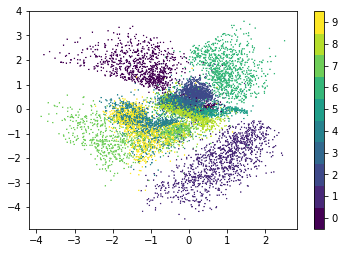

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

# Compute mean vectors of variational distributions (= latent code locations)
q_test_mean, _ = vae.encode(x_test)

# Use a discrete colormap
cmap = plt.get_cmap('viridis', 10)

# Plot latent code locations colored by the digit value on input images
im = plt.scatter(q_test_mean[:, 0], q_test_mean[:, 1], c=y_test, cmap=cmap, 
                 vmin=-0.5, vmax=9.5, marker='x', s=0.2)

plt.colorbar(im, ticks=range(10));

When we sample locations in latent space (with density proportional to the prior density over latent variables) and decode these locations we can get a nice overview how MNIST digits are organized by structural similarity in latent space. Each digit is plotted with its expected pixel values k instead of using a sample from the corresponding multivariate Bernoulli distribution.

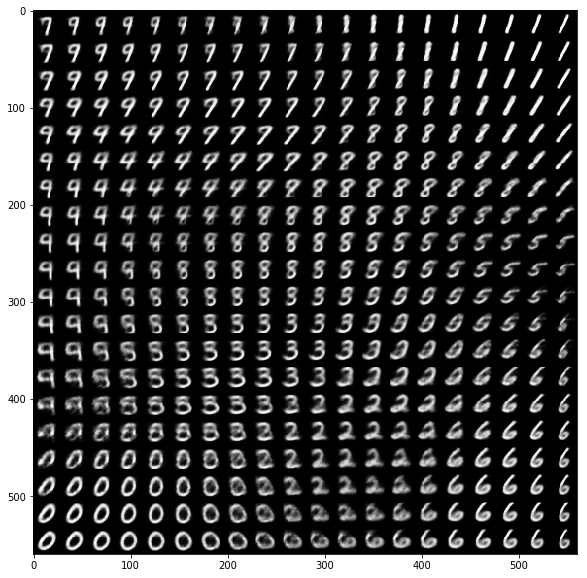

In [10]:
import numpy as np

from scipy.stats import norm

# Number of samples per latent space dimension
samples_per_dim = 20

# Size of plotted digits
digit_size = 28

# Sampling grid coordinates. Grid points density is
# proportial to density of latent variable prior.
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim, 
                   digit_size * samples_per_dim))

for i, x in enumerate(grid_x):
    for j, y in enumerate(grid_y):
        t_ij = np.array([[x, y]])
        x_ij = vae.decode(t_ij)
        digit = x_ij.numpy().reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

## References

\[1\] Diederik P. Kingma, Max Welling [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).  
\[2\] François Chollet. [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).  